#  Сегментация изображений

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation/data
* https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
* https://amaarora.github.io/posts/2020-09-13-unet.html
* https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
* https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8
* https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
* https://huggingface.co/docs/transformers/model_doc/segformer
* https://www.kaggle.com/code/damianpanek/segformerb0-people-clothing-segmentation

## Задачи для совместного разбора

1\. Обсудите постановку задачи сегментации изображений.

2\. Рассмотрите пример работы слоя `ConvTranspose2d`.

In [1]:
import torch
import torch.nn as nn

In [2]:
img = torch.arange(0, 4).reshape(1, 1, 2, 2).float()
img

tensor([[[[0., 1.],
          [2., 3.]]]])

In [3]:
layer = nn.ConvTranspose2d(
    in_channels=1,
    out_channels=1,
    kernel_size=3,
    bias=False,
)

layer(img)

tensor([[[[ 0.0000, -0.1802, -0.1944, -0.1124],
          [-0.3604, -0.6503, -0.9386, -0.0698],
          [ 0.5584,  0.5531,  0.4588,  0.5781],
          [-0.0467,  0.5606,  0.4971, -0.6734]]]],
       grad_fn=<ConvolutionBackward0>)

In [4]:
res = torch.zeros(4, 4)
w = layer.weight.squeeze()
x = img.squeeze()

res[:3, :3] += w * x[0, 0]
res[:3, 1:4] += w * x[0, 1]
res[1:4, :3] += w * x[1, 0]
res[1:4, 1:4] += w * x[1, 1]
res

tensor([[ 0.0000, -0.1802, -0.1944, -0.1124],
        [-0.3604, -0.6503, -0.9386, -0.0698],
        [ 0.5584,  0.5531,  0.4588,  0.5781],
        [-0.0467,  0.5606,  0.4971, -0.6734]], grad_fn=<CopySlices>)

## Задачи для самостоятельного решения

<p class='task' id='1'></p>

1\. Опишите датасет `ClothesSegmentationDataset`. Реализуйте `__getitem__` таким образом, чтобы он возвращал два элемента: тензор с изображением и тензор с маской. Маска должна быть представлена трехмерным тензором целых чисел. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений и масок. Создайте объект датасета и выведите на экран форму и типы одного изображения и его маски.

- [ ] Проверено на семинаре

In [5]:
from torch.utils.data import Dataset
from torchvision.transforms import Compose, Normalize, Resize, ToTensor
from PIL import Image
import numpy as np
import torch as th

In [6]:
import kagglehub
from pathlib import Path

dataset_path = Path(kagglehub.dataset_download('rajkumarl/people-clothing-segmentation', force_download=False))
dataset_path

PosixPath('/home/kekwak/.cache/kagglehub/datasets/rajkumarl/people-clothing-segmentation/versions/2')

In [7]:
class ClothesSegmentationDataset(Dataset):
    def __init__(self, dataset_path, image_transform=None, mask_transform=None):
        self.dataset_path = dataset_path
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        
        self.images_path = dataset_path / 'png_images' / 'IMAGES'
        self.masks_path = dataset_path / 'png_masks' / 'MASKS'

        self.images = list(self.images_path.iterdir())
        self.masks = [
            self.masks_path / i.name.replace('img', 'seg')
            for i in self.images
        ]
    
    def get_random_element(self):
        index = np.random.randint(0, len(self))
        return self.__getitem__(index)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_path = self.images[index]
        mask_path = self.masks[index]

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path)

        if self.image_transform:
            image = self.image_transform(image)
        else:
            image = ToTensor()(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        mask = th.tensor(np.array(mask, dtype=np.int64))

        if mask.ndim == 2:
            mask = mask.unsqueeze(0)

        return image, mask

In [8]:
image_transform = Compose([
    Resize((256, 256)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
mask_transform = Compose([
    Resize((256, 256)),
])

In [9]:
dataset = ClothesSegmentationDataset(dataset_path, image_transform, mask_transform)
image, mask = dataset.get_random_element()
image.shape, mask.shape

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

<p class='task' id='2'></p>

2\. Напишите функцию `show_image_with_mask`, которая выводит рядом два изображения: фотографию и маску. Продемонстрируйте работу функции, взяв один пример из созданного датасета.

- [ ] Проверено на семинаре

In [10]:
from matplotlib import pyplot as plt

In [14]:
def denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image * std + mean

def show_image_with_mask(image, mask, mask2=None, do_denormalize=True):
    if do_denormalize:
        image = denormalize(image)
    fig, ax = plt.subplots(1, 3 if mask2 is not None else 2, figsize=(10, 5))

    ax[0].imshow(image.permute(1, 2, 0), cmap='nipy_spectral')
    ax[0].set_title('Image')
    ax[0].axis('off')

    ax[1].imshow(mask.squeeze(), cmap='nipy_spectral')
    ax[1].set_title('Mask')
    ax[1].axis('off')

    if mask2 is not None:
        ax[2].imshow(mask2.squeeze(), cmap='nipy_spectral')
        ax[2].set_title('Model')
        ax[2].axis('off')

    fig.tight_layout()
    fig.show()

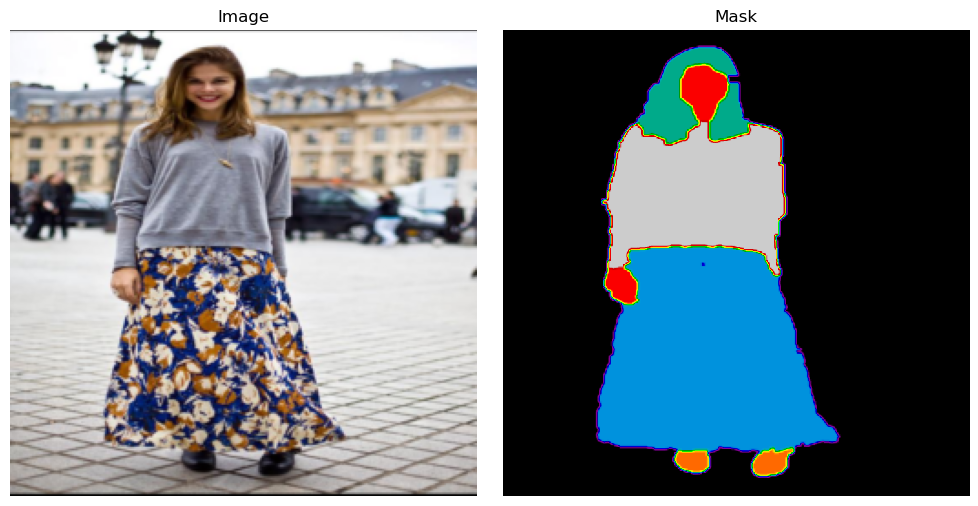

In [15]:
image, mask = dataset.get_random_element()
show_image_with_mask(image, mask)

<p class='task' id='3'></p>

3\. Реализуйте архитектуру U-Net. Реализуйте модель таким образом, чтобы на выходе для каждого изображения получался тензор размера `n_classes x h x w`, где `n_classes` - количество уникальных значений в масках, а `h` и `w` - размер исходного изображения. Возьмите один пример из набора данных и пропустите его через сеть. Выведите форму полученного результата на экран.

- [ ] Проверено на семинаре

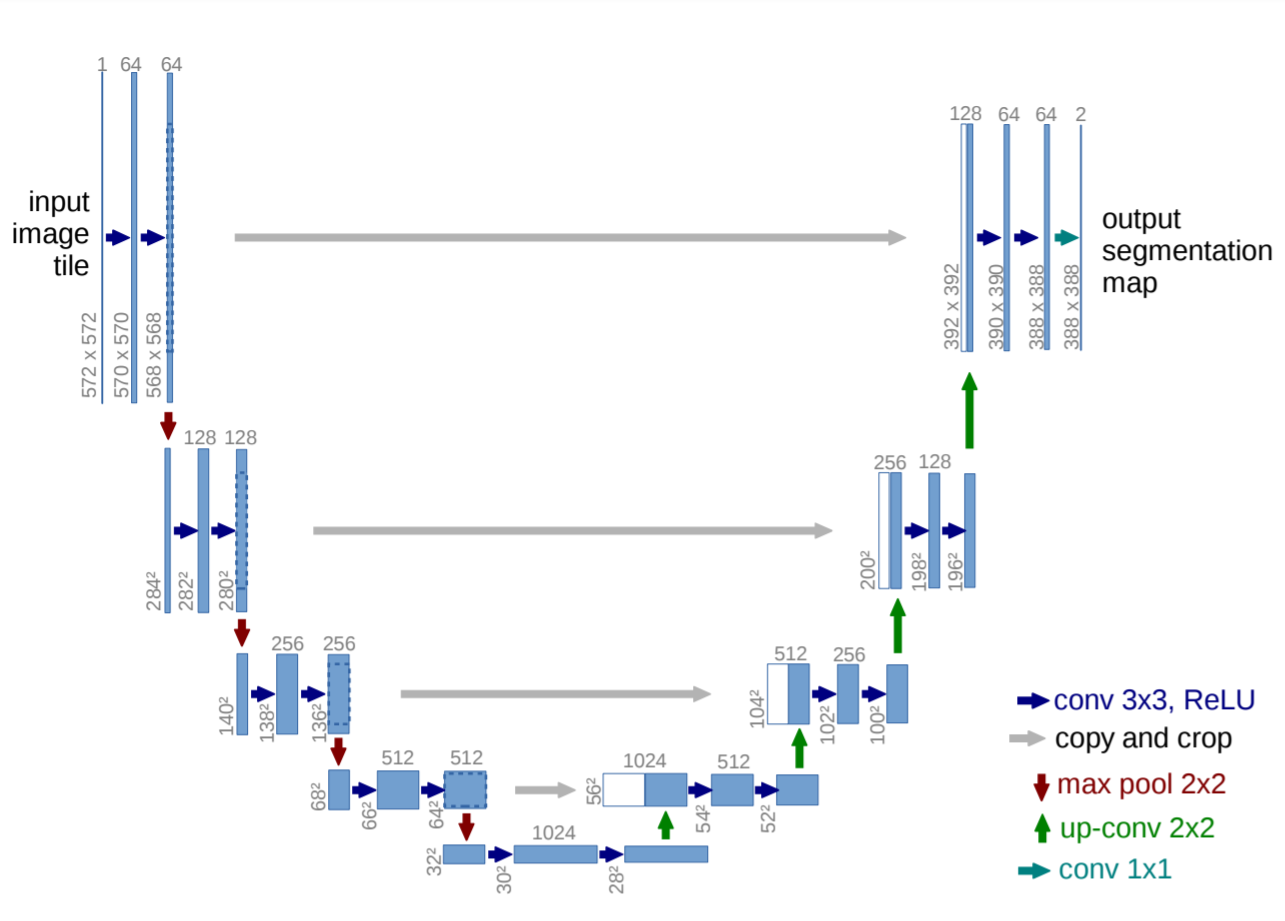

In [16]:
from torch import nn, optim

In [17]:
class UNet(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(UNet, self).__init__()

        def conv_block(in_ch, out_ch):
            block = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )
            return block

        def up_conv_block(in_ch, out_ch):
            block = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
            return block

        self.max_pool = nn.MaxPool2d(2)

        self.down1 = conv_block(in_channels, 64)
        self.down2 = conv_block(64, 128)
        self.down3 = conv_block(128, 256)
        self.down4 = conv_block(256, 512)
        self.down5 = conv_block(512, 1024)

        self.up1 = up_conv_block(1024, 512)
        self.up_conv1 = conv_block(1024, 512)
        self.up2 = up_conv_block(512, 256)
        self.up_conv2 = conv_block(512, 256)
        self.up3 = up_conv_block(256, 128)
        self.up_conv3 = conv_block(256, 128)
        self.up4 = up_conv_block(128, 64)
        self.up_conv4 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(self.max_pool(x1))
        x3 = self.down3(self.max_pool(x2))
        x4 = self.down4(self.max_pool(x3))
        x5 = self.down5(self.max_pool(x4))

        x4u = self.up1(x5)
        x4u = self.up_conv1(
            torch.cat([x4, x4u], dim=1)
        )

        x3u = self.up2(x4u)
        x3u = self.up_conv2(
            torch.cat([x3, x3u], dim=1)
        )

        x2u = self.up3(x3u)
        x2u = self.up_conv3(
            torch.cat([x2, x2u], dim=1)
        )

        x1u = self.up4(x2u)
        x1u= self.up_conv4(
            torch.cat([x1, x1u], dim=1)
        )

        output = self.final_conv(x1u)
        return output

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [18]:
model = UNet(3, 59)
image, mask = dataset.get_random_element()
image = image.unsqueeze(0)
out = model(image)
image.shape, out.shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 59, 256, 256]))

<p class='task' id='4'></p>

4\.  Разбейте набор данных на обучающее и валидационное множество. Обучите модель U-Net для сегментации изображения. Во время обучения выводите на экран значения функции потерь и точности прогнозов на обучающем и валидационном множестве. Обратите внимание, что выборка является несбалансированной. При расчете функции потерь примените любую известную вам технику для работы с несбалансированными выборками.

При создании датасета допускается использовать преобразования, уменьшающие размер изображений (для ускорения процесса обучения).

Используя обученную модель, получите предсказания для нескольких изображений и отрисуйте их.
- [ ] Проверено на семинаре

In [19]:
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

In [20]:
image_transform = Compose([
    Resize((256, 256)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
mask_transform = Compose([
    Resize((256, 256)),
])
dataset = ClothesSegmentationDataset(dataset_path, image_transform, mask_transform)
image, mask = dataset.get_random_element()
image.shape, mask.shape

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

In [21]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
dataset_train, dataset_val = random_split(dataset, [0.8, 0.2])
loader_train = DataLoader(dataset_train, batch_size=4, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=4, shuffle=False)

In [22]:
class_counts = np.zeros(59)
for _, mask in dataset:
    unique, counts = np.unique(mask.numpy(), return_counts=True)
    class_counts[unique] += counts
class_weights = 1 / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = th.tensor(class_weights, dtype=th.float32).to(device)

In [ ]:
model = UNet(in_channels=3, n_classes=59).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-4)

In [24]:
def calculate_iou(pred, target, num_classes):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)

In [25]:
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    train_loss = []
    train_iou = []

    for images, masks in tqdm(loader_train, desc=f'Epoch {epoch+1}/{num_epochs} Train'):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.squeeze(1))
        iou = calculate_iou(outputs.argmax(dim=1), masks, 59)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_iou.append(iou)

    model.eval()
    val_loss = []
    val_iou = []

    with torch.no_grad():
        for images, masks in tqdm(loader_val, desc=f'Epoch {epoch+1}/{num_epochs} Val'):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks.squeeze(1))
            iou = calculate_iou(outputs.argmax(dim=1), masks, 59)
            val_loss.append(loss.item())
            val_iou.append(iou)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {np.mean(train_loss):.4f}, Val Loss: {np.mean(val_loss):.4f}\n' \
          f'Train IoU: {np.nanmean(train_iou):.4f}, Val IoU: {np.nanmean(val_iou):.4f}')

Epoch 1/25 Val: 100%|██████████| 50/50 [00:03<00:00, 14.14it/s]


Epoch 1/25
Train Loss: 1.5185, Val Loss: 1.0238
Train IoU: 0.0137, Val IoU: 0.0145


Epoch 2/25 Val: 100%|██████████| 50/50 [00:03<00:00, 14.18it/s]


Epoch 2/25
Train Loss: 0.9931, Val Loss: 0.9376
Train IoU: 0.0164, Val IoU: 0.0216


Epoch 3/25 Val: 100%|██████████| 50/50 [00:03<00:00, 13.96it/s]


Epoch 3/25
Train Loss: 0.9250, Val Loss: 0.9007
Train IoU: 0.0250, Val IoU: 0.0253


Epoch 4/25 Val: 100%|██████████| 50/50 [00:03<00:00, 13.86it/s]


Epoch 4/25
Train Loss: 0.8914, Val Loss: 0.8740
Train IoU: 0.0303, Val IoU: 0.0291


Epoch 5/25 Val: 100%|██████████| 50/50 [00:03<00:00, 13.91it/s]


Epoch 5/25
Train Loss: 0.8635, Val Loss: 0.8606
Train IoU: 0.0355, Val IoU: 0.0383


Epoch 6/25 Val: 100%|██████████| 50/50 [00:03<00:00, 13.96it/s]


Epoch 6/25
Train Loss: 0.8465, Val Loss: 0.8539
Train IoU: 0.0385, Val IoU: 0.0385


Epoch 7/25 Val: 100%|██████████| 50/50 [00:03<00:00, 13.36it/s]


Epoch 7/25
Train Loss: 0.8198, Val Loss: 0.8404
Train IoU: 0.0413, Val IoU: 0.0372


Epoch 8/25 Val: 100%|██████████| 50/50 [00:03<00:00, 13.92it/s]


Epoch 8/25
Train Loss: 0.7992, Val Loss: 0.7988
Train IoU: 0.0442, Val IoU: 0.0445


Epoch 9/25 Val: 100%|██████████| 50/50 [00:03<00:00, 13.57it/s]


Epoch 9/25
Train Loss: 0.7852, Val Loss: 0.7913
Train IoU: 0.0461, Val IoU: 0.0423


Epoch 10/25 Val: 100%|██████████| 50/50 [00:03<00:00, 13.26it/s]


Epoch 10/25
Train Loss: 0.7560, Val Loss: 0.7578
Train IoU: 0.0487, Val IoU: 0.0462


Epoch 11/25 Val: 100%|██████████| 50/50 [00:03<00:00, 13.69it/s]


Epoch 11/25
Train Loss: 0.7318, Val Loss: 0.7365
Train IoU: 0.0508, Val IoU: 0.0511


Epoch 12/25 Val: 100%|██████████| 50/50 [00:03<00:00, 14.24it/s]


Epoch 12/25
Train Loss: 0.7164, Val Loss: 0.7027
Train IoU: 0.0535, Val IoU: 0.0544


Epoch 13/25 Val: 100%|██████████| 50/50 [00:03<00:00, 13.21it/s]


Epoch 13/25
Train Loss: 0.6815, Val Loss: 0.6828
Train IoU: 0.0574, Val IoU: 0.0570


Epoch 14/25 Val: 100%|██████████| 50/50 [00:03<00:00, 13.52it/s]


Epoch 14/25
Train Loss: 0.6589, Val Loss: 0.6542
Train IoU: 0.0609, Val IoU: 0.0618


Epoch 15/25 Val: 100%|██████████| 50/50 [00:03<00:00, 14.11it/s]


Epoch 15/25
Train Loss: 0.6400, Val Loss: 0.6514
Train IoU: 0.0627, Val IoU: 0.0600


Epoch 16/25 Val: 100%|██████████| 50/50 [00:03<00:00, 13.27it/s]


Epoch 16/25
Train Loss: 0.6206, Val Loss: 0.6367
Train IoU: 0.0653, Val IoU: 0.0635


Epoch 17/25 Val: 100%|██████████| 50/50 [00:03<00:00, 14.15it/s]


Epoch 17/25
Train Loss: 0.6048, Val Loss: 0.6275
Train IoU: 0.0687, Val IoU: 0.0665


Epoch 18/25 Val: 100%|██████████| 50/50 [00:03<00:00, 13.99it/s]


Epoch 18/25
Train Loss: 0.5920, Val Loss: 0.6086
Train IoU: 0.0718, Val IoU: 0.0701


Epoch 19/25 Val: 100%|██████████| 50/50 [00:03<00:00, 13.81it/s]


Epoch 19/25
Train Loss: 0.5719, Val Loss: 0.6100
Train IoU: 0.0745, Val IoU: 0.0725


Epoch 20/25 Val: 100%|██████████| 50/50 [00:03<00:00, 13.80it/s]


Epoch 20/25
Train Loss: 0.5563, Val Loss: 0.6013
Train IoU: 0.0780, Val IoU: 0.0721


Epoch 21/25 Val: 100%|██████████| 50/50 [00:03<00:00, 14.04it/s]


Epoch 21/25
Train Loss: 0.5415, Val Loss: 0.6096
Train IoU: 0.0805, Val IoU: 0.0734


Epoch 22/25 Val: 100%|██████████| 50/50 [00:03<00:00, 13.54it/s]


Epoch 22/25
Train Loss: 0.5297, Val Loss: 0.5920
Train IoU: 0.0843, Val IoU: 0.0777


Epoch 23/25 Val: 100%|██████████| 50/50 [00:03<00:00, 14.12it/s]


Epoch 23/25
Train Loss: 0.5113, Val Loss: 0.6015
Train IoU: 0.0872, Val IoU: 0.0805


Epoch 24/25 Val: 100%|██████████| 50/50 [00:03<00:00, 13.86it/s]


Epoch 24/25
Train Loss: 0.4959, Val Loss: 0.5858
Train IoU: 0.0916, Val IoU: 0.0822


Epoch 25/25 Val: 100%|██████████| 50/50 [00:03<00:00, 13.70it/s]

Epoch 25/25
Train Loss: 0.4816, Val Loss: 0.6433
Train IoU: 0.0946, Val IoU: 0.0788


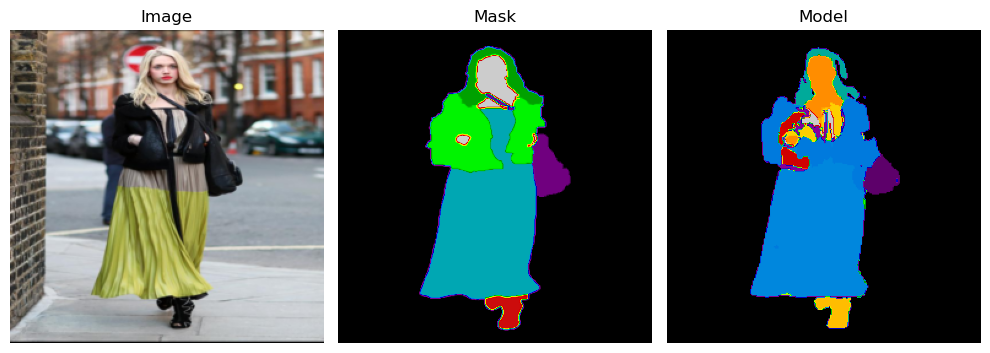

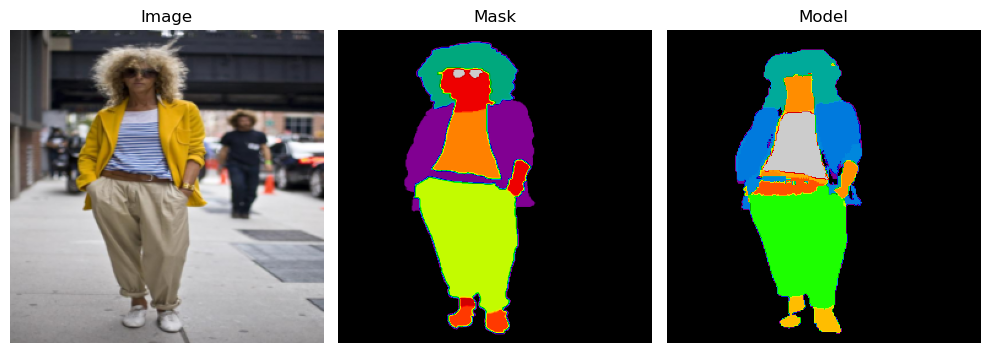

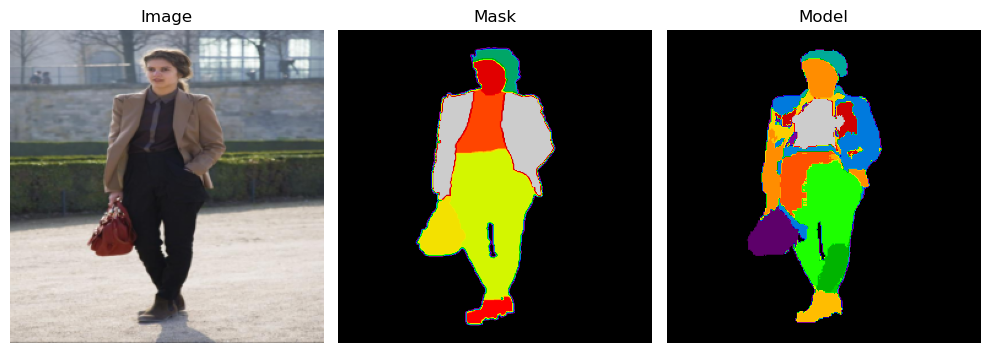

In [26]:
for _ in range(3):
    image, mask = dataset.get_random_element()
    out = model(image.unsqueeze(0).to(device))
    show_image_with_mask(image.cpu(), mask, out[0].argmax(0).cpu())

<p class='task' id='5'></p>

5\.  Обучите модуль `SegformerForSemanticSegmentation` из пакета `transformers` для сегментации изображения. Во время обучения выводите на экран значения функции потерь и точности прогнозов на обучающем и валидационном множестве. Для оптимизации используйте значение функции потерь, которое возвращает вам модель.

Используя обученную модель, получите предсказания для нескольких изображений и отрисуйте их.
- [ ] Проверено на семинаре

In [27]:
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor

In [28]:
dataset = ClothesSegmentationDataset(dataset_path)
image, mask = dataset.get_random_element()

dataset_train, dataset_val = random_split(dataset, [0.8, 0.2])
loader_train = DataLoader(dataset_train, batch_size=4, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=4, shuffle=False)

In [29]:
model = SegformerForSemanticSegmentation.from_pretrained(
    'nvidia/segformer-b0-finetuned-ade-512-512',
    num_labels=59, ignore_mismatched_sizes=True,
).to(device)
processor = SegformerImageProcessor()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([59]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([59, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = []

    for images, masks in tqdm(loader_train, desc=f'Epoch {epoch+1}/{num_epochs} Train'):
        images = images.to(device)
        inputs = processor(images, return_tensors='pt').to(device)
        masks = masks.squeeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(**inputs, labels=masks)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
    
    model.eval()
    val_loss = []

    with torch.no_grad():
        for images, masks in tqdm(loader_val, desc=f'Epoch {epoch+1}/{num_epochs} Val'):
            images = denormalize(images).to(device)
            inputs = processor(images, return_tensors='pt').to(device)
            masks = masks.squeeze(1).to(device)

            outputs = model(**inputs, labels=masks)
            val_loss.append(outputs.loss.item())

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {np.mean(train_loss):.4f}, Val Loss: {np.mean(val_loss):.4f}\n')

Epoch 1/20 Val: 100%|██████████| 50/50 [00:09<00:00,  5.33it/s]


Epoch 1/20
Train Loss: 3.0852, Val Loss: 2.2414



Epoch 2/20 Val: 100%|██████████| 50/50 [00:09<00:00,  5.36it/s]


Epoch 2/20
Train Loss: 1.7041, Val Loss: 1.3771



Epoch 3/20 Val: 100%|██████████| 50/50 [00:09<00:00,  5.34it/s]


Epoch 3/20
Train Loss: 1.1302, Val Loss: 1.0481



Epoch 4/20 Val: 100%|██████████| 50/50 [00:09<00:00,  5.41it/s]


Epoch 4/20
Train Loss: 0.8878, Val Loss: 0.8857



Epoch 5/20 Val: 100%|██████████| 50/50 [00:09<00:00,  5.39it/s]


Epoch 5/20
Train Loss: 0.7795, Val Loss: 0.8311



Epoch 6/20 Val: 100%|██████████| 50/50 [00:09<00:00,  5.42it/s]


Epoch 6/20
Train Loss: 0.7093, Val Loss: 0.8089



Epoch 7/20 Val: 100%|██████████| 50/50 [00:09<00:00,  5.39it/s]


Epoch 7/20
Train Loss: 0.6611, Val Loss: 0.7292



Epoch 8/20 Val: 100%|██████████| 50/50 [00:09<00:00,  5.34it/s]


Epoch 8/20
Train Loss: 0.6194, Val Loss: 0.7097



Epoch 9/20 Val: 100%|██████████| 50/50 [00:09<00:00,  5.37it/s]


Epoch 9/20
Train Loss: 0.5874, Val Loss: 0.7299



Epoch 10/20 Val: 100%|██████████| 50/50 [00:09<00:00,  5.45it/s]


Epoch 10/20
Train Loss: 0.5509, Val Loss: 0.6214



Epoch 11/20 Val: 100%|██████████| 50/50 [00:09<00:00,  5.35it/s]


Epoch 11/20
Train Loss: 0.5262, Val Loss: 0.6375



Epoch 12/20 Val: 100%|██████████| 50/50 [00:09<00:00,  5.39it/s]


Epoch 12/20
Train Loss: 0.5121, Val Loss: 0.6593



Epoch 13/20 Val: 100%|██████████| 50/50 [00:09<00:00,  5.34it/s]


Epoch 13/20
Train Loss: 0.4872, Val Loss: 0.5912



Epoch 14/20 Val: 100%|██████████| 50/50 [00:09<00:00,  5.37it/s]


Epoch 14/20
Train Loss: 0.4625, Val Loss: 0.5450



Epoch 15/20 Val: 100%|██████████| 50/50 [00:09<00:00,  5.32it/s]


Epoch 15/20
Train Loss: 0.4415, Val Loss: 0.5661



Epoch 16/20 Val: 100%|██████████| 50/50 [00:09<00:00,  5.40it/s]


Epoch 16/20
Train Loss: 0.4262, Val Loss: 0.5247



Epoch 17/20 Val: 100%|██████████| 50/50 [00:09<00:00,  5.34it/s]


Epoch 17/20
Train Loss: 0.4065, Val Loss: 0.5043



Epoch 18/20 Val: 100%|██████████| 50/50 [00:09<00:00,  5.30it/s]


Epoch 18/20
Train Loss: 0.4103, Val Loss: 0.5748



Epoch 19/20 Val: 100%|██████████| 50/50 [00:09<00:00,  5.27it/s]


Epoch 19/20
Train Loss: 0.3888, Val Loss: 0.5552



Epoch 20/20 Val: 100%|██████████| 50/50 [00:09<00:00,  5.39it/s]

Epoch 20/20
Train Loss: 0.3658, Val Loss: 0.4771



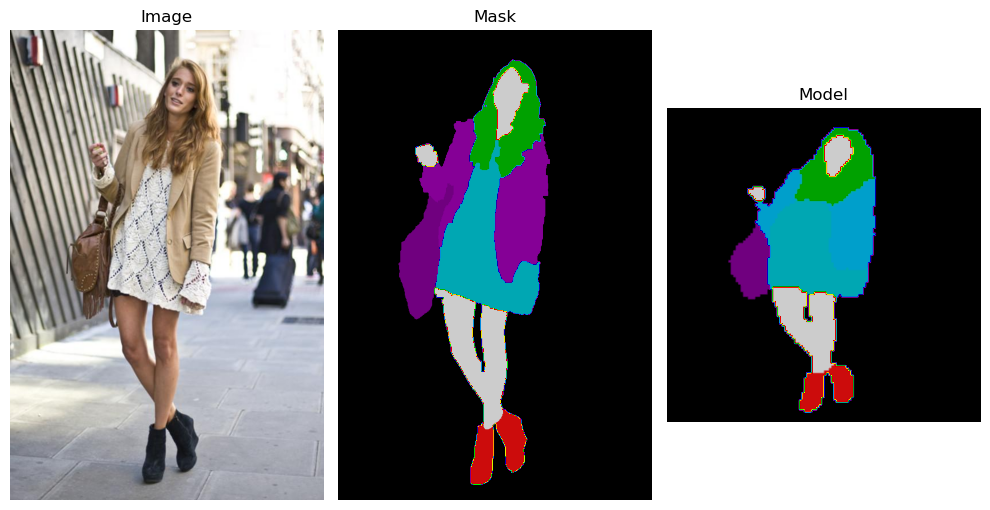

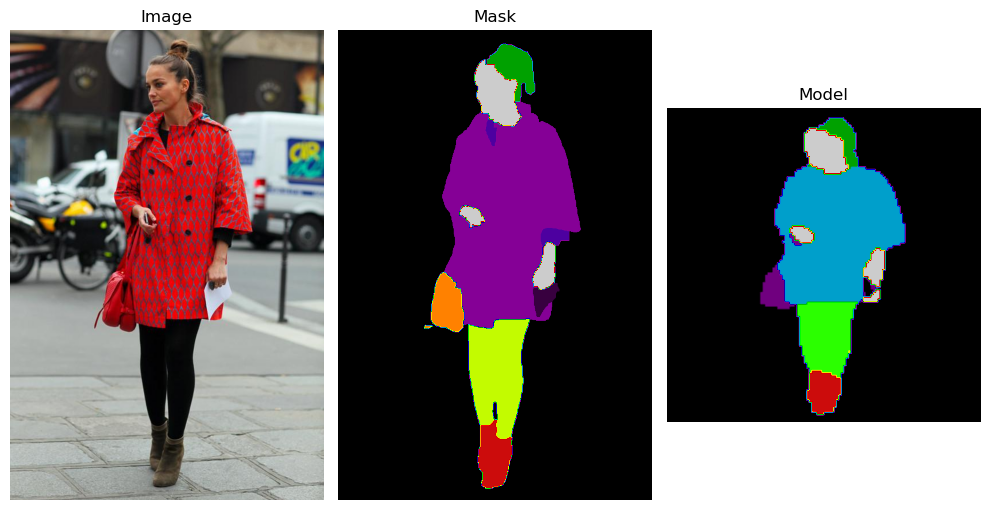

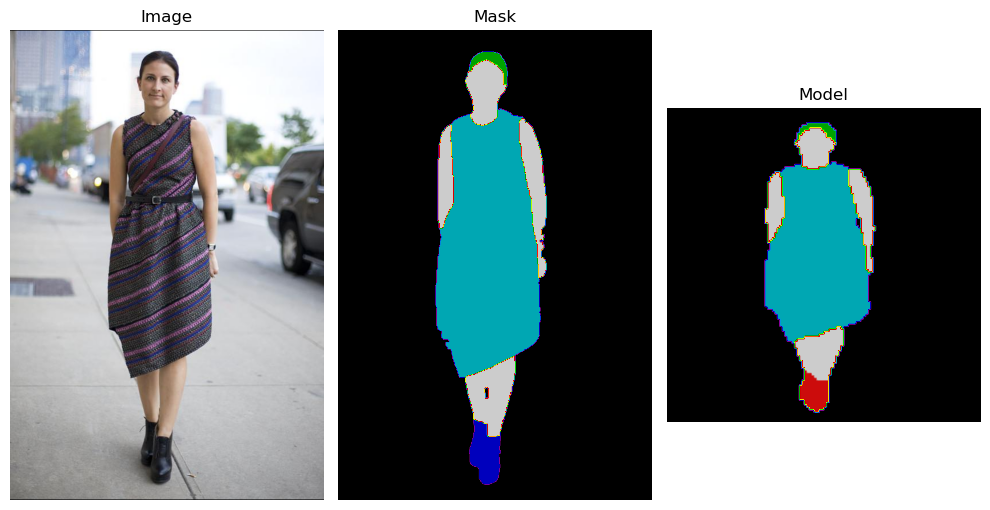

In [43]:
for _ in range(3):
    image, mask = dataset.get_random_element()
    image_m = image.clone().unsqueeze(0).to(device)
    inputs = processor(image_m, return_tensors='pt').to(device)
    out = model(**inputs).logits[0].argmax(0).cpu()
    show_image_with_mask(image, mask, out, do_denormalize=False)